ionize Tutorial
===============

**ionize** is a Python module for calculating the properties of ions in aqueous solution. 

To load the library, simply import **ionize**.

In [1]:
import ionize

# We'll also import numpy to set up some of our inputs. 
# And pprint to prettily print some lists.
import numpy
import pprint

# And set up inline plotting.
from matplotlib.pyplot import *
%matplotlib inline

# Prettify numpy printing
numpy.set_printoptions(precision=3)

Ion
----
The basic building block of an **ionize** simulation is an ionic species, modeled by the **Ion** class. Call **ionize**.**Ion**(*name*, *z*, *pKa*, *absolute_mobility*). *name* is the name of the ion, typically as a string. *z* is a list containing the charge states of the ion. *pKa* is a list of the pKas of the charge states, with the same order as the list *z*. *absolute_mobility* is a list containing the absolute, infinite dilution mobilities of each charge state, ordered the same as the other two lists, in units of m<sup>2</sup>V<sup>-1</sup>s<sup>-1</sup>.

In [2]:
# Initialize an ion and print it. 
acid = ionize.Ion('myAcid', [-1], [5], [-25e-9])
base = ionize.Ion('myBase', [1], [8], [20e-9])
print acid
print base

Ion('myAcid')
Ion('myBase')


In [3]:
aspartic = ionize.Database().load('aspartic acid')
print aspartic.ionization_fraction(8)

[  9.925e-03   9.900e-01   1.498e-10]


Once an ion species is initialized, you can call the properties of the ion, typically as a function of pH and ionic strength. 

myAcid Ka at (I=0 M) = [  1.001e-05]
myAcid Ka at (I=0.5 M) = [  1.783e-05]


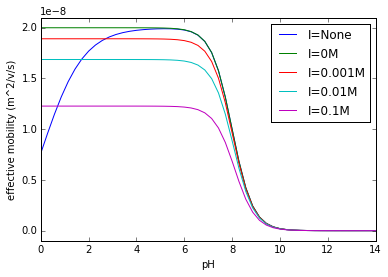

In [4]:
print 'myAcid Ka at (I=0 M) =', acid.acidity()
print 'myAcid Ka at (I=0.5 M) =', acid.acidity(ionic_strength=0.5)

pH = numpy.linspace(0,14)

for I in [None, 0, 0.001, 0.01, 0.1]:
    mu = [base.mobility(p, I) for p in pH]
    if I is not None:
        label = 'I={}M'.format(I)
    else:
        label = 'I=None'
    plot(pH, mu, label=label)

xlabel('pH'); xlim(0, 14)
ylabel('effective mobility (m^2/v/s)'); ylim(-.1e-8, 2.1e-8)
legend()
show()

## Using the **ionize** database

### load_ion()
Individually initializing ions is error-prone and time-consuming. To simplify the process, load ionic species from a database using the **load_ion** function. Call **ionize**.**load_ion**(*name*), where *name* is the case-insensitive full name of an ionic species. The function returns an Ion object, or *None* if the object is not available. 

Ion('histidine')
Ion(name='histidine', valence=[-1, 1, 2], reference_pKa=[9.33, 6.04, 2.0], reference_mobility=[-2.8300000000000002e-08, 2.8800000000000003e-08, 4.47e-08], reference_temperature=25.0, enthalpy=[43800.0, 29500.0, 3600.0], heat_capacity=[-233.0, 176.0, 0.0], nightingale_data=None)


ionize/Ion/acidity.py:48: UserWarning: Using the van't Hoff correction for dT > 20 deg.
  warnings.warn("Using the van't Hoff correction for dT > 20 deg.")


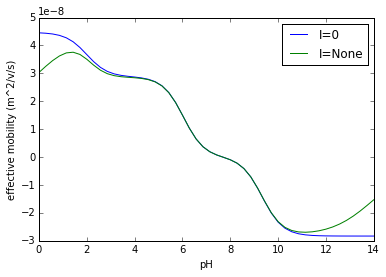

In [5]:
database = ionize.Database()
histidine = database.load('histidine')
print histidine
print repr(histidine)
[database.load('histidine').pKa(0, t) for t in np.linspace(0, 50)]


for ionic_strength in (0, None):
    mu_histidine = [histidine.mobility(p, ionic_strength=ionic_strength) for p in pH]
    plot(pH, mu_histidine, label="I={}".format(ionic_strength))
    
xlabel('pH'); xlim([0, 14])
ylabel('effective mobility (m^2/v/s)')
legend()
show()

### search_ion()

You can also search for ions in the database by name using **search_ion()**. Call it by specifying a *search_string*. **search_ion()** will print the names of all ions that contain the *search_string*. **search_ion** will not return any results, so call **load_ion** when you find what you want. 

In [6]:
print "Search results for 'amino'\n--------------------------"
pprint.pprint(database.search('amino'))
print "\nSearch results for 'chloric'\n---------------------------"
pprint.pprint(database.search('chloric'))
print "\nSearch results for 'per'\n------------------------"
pprint.pprint(database.search('per'))
print '\nOh, copper is what I was looking for.'
print database.load('copper')


Search results for 'amino'
--------------------------
('2-amino-2-methyl-1-propanol',
 'e-aminocaproic acid',
 'o-aminobenzoic acid',
 'p-aminobenzoic acid')

Search results for 'chloric'
---------------------------
('chloric acid', 'hydrochloric acid', 'perchloric acid')

Search results for 'per'
------------------------
('copper',
 'diperodone',
 'perchloric acid',
 'periodic acid',
 'permanganic acid',
 'peroxysulfuric acid',
 'perrhenic acid',
 'piperidine')

Oh, copper is what I was looking for.
Ion('copper')


### get_db()
You can also directly call the database used by both **load_ion** and **search_ion** using **get_db**. This returns the database as a dictionary.

In [7]:
print len(database.data), 'ions in database.'

508 ions in database.


Solution
--------
Getting the properties of a single ionic species in solution is useful, but the real challenge of dealing with aqueous solutions of ions is finding properties based on the equilibrium state of multiple ionic species. **ionize** can perform those calculations using the **Solution** class. **Solution** objects are initialized using **ionize**.**Solution**(*ions*, *concentrations*), where ions is a list of **Ion** objects and concentration is a list concentrations of the ions, with concentrations in molar.

In [8]:
hcl=database.load('hydrochloric acid')
tris=database.load('tris')
buffer=ionize.Solution([tris, hcl], [0.1, 0.085])

print 'pH =', buffer.pH
print 'I =', buffer.ionic_strength, 'M'
print 'conductivity =', buffer.conductivity(), 'S/m'
print 'buffering capacity =', buffer.buffering_capacity(), 'M'
print 'debye length =', buffer.debye(), 'm'

pH = 7.41791879345
I = 0.0850004156877 M
conductivity = 0.743736433035 S/m
buffering capacity = 0.0295707551228 M
debye length = 8.70277734293e-11 m


**Solutions** can be initialized with ion names instead of ions. If so, the **Solution** calls **load_ion** to determine the ion identities.

In [9]:
print [ion.name for ion in ionize.Solution(['bis-tris', 'acetic acid'], [0.1, 0.03]).ions]
print ionize.Solution(['bis-tris', 'acetic acid'], [0.1, 0.03]).concentration(database.load('acetic acid'))

['bis-tris', 'acetic acid']
0.03


We can iterate through solutions to quickly calculate the pH of a titration between two ions

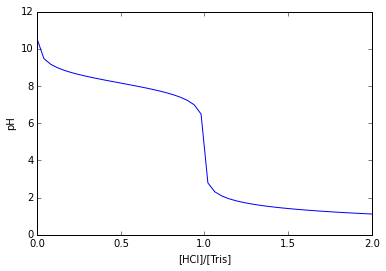

In [10]:
c_tris = 0.1
c_hcl = numpy.linspace(0.0, 0.2, 50)
t_pH = [ionize.Solution(['tris', 'hydrochloric acid'], [c_tris, c_h], temperature=25).pH for c_h in c_hcl]

plot(c_hcl/c_tris, t_pH)
xlabel('[HCl]/[Tris]')
ylabel('pH')
show()

A **Solution** can also be initialized without ions, e.g. as water. 

In [11]:
water = ionize.Solution()
print 'I =', water.ionic_strength, 'M'
print 'pH =', water.pH
print 'conductivity =', water.conductivity(), 'S/m'

I = 1e-07 M
pH = 7.0
conductivity = 5.47364018279e-06 S/m


A **Solution** can also be added and multiplied through operator overloading. This can be useful when calculating the results of diltuions, as below. 

In [12]:
print 'Stock:', buffer
dilution = 0.5 * buffer + 0.5 * water
print 'Dilution:', dilution

Stock: Solution(pH=7.42, I=0.085 M)
Dilution: Solution(pH=7.4, I=0.0425 M)


**Solutions** can be titrated to a specified pH. To do so, make a solution, and then specify a titrant, a property, and a target.  

In [13]:
buff = ionize.Solution([tris], 0.1)

In [14]:
print buff.titrate('hydrochloric acid', 8.2)
print buff.titrate('hydrochloric acid', 3)
print repr(buff.titrate('hydrochloric acid', 3, titration_property = 'conductivity'))
print repr(buff.titrate('hydrochloric acid', 8))


Solution(pH=8.2, I=0.0474 M)
Solution(pH=3, I=0.101 M)
Solution(ions=['tris', 'hydrochloric acid'], concentrations=[0.1, 0.156065882386896], temperature=25.0)
Solution(ions=['tris', 'hydrochloric acid'], concentrations=[0.1, 0.059175833516811535], temperature=25.0)


ionize/Solution/equilibrium.py:153: UserWarning: Ionic strength > 1M. Ionic stregth correction may be inaccurate.
  warnings.warn(('Ionic strength > 1M. '


Temperature Effects
-------------------
Both **Ion** objects and **Solution** objects take T as an optional argument for temperature. Temperature should be specified in degrees C. 

**Ion** objects adjust their absolute mobility and pKa attributes based on temperature. They also make adjustments to their ionic strength correction algorithms based on temperature. The type of temperature adjustment data depends on the specific ion. For small ions, emperical data from literature is included. For organic molecules, &Delta;H and &Delta;Cp values may be provided. All ions also correct their mobilities for viscosity. 

ionize/Ion/acidity.py:28: UserWarning: No data available to correct pKa for temperature.
  warnings.warn('No data available to correct pKa for temperature.')


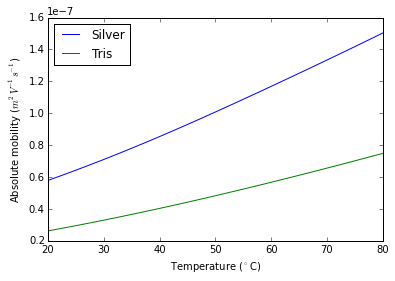

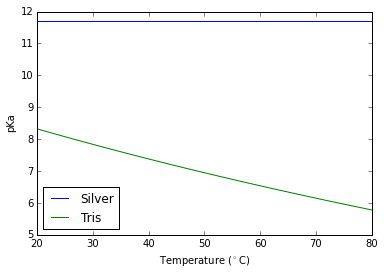

In [15]:
silver = database.load('silver')
tris = database.load('tris')
T = numpy.linspace(20.0, 80.0)
mu_silver = [silver.absolute_mobility(Tp) for Tp in T]
mu_tris = [tris.absolute_mobility(Tp) for Tp in T]
pKa_silver = [silver.pKa(0, Tp) for Tp in T]
pKa_tris = [tris.pKa(0, Tp) for Tp in T]

figure()
plot(T, mu_silver, label = 'Silver')
plot(T, mu_tris, label = 'Tris')
legend(loc = 'upper left')
xlabel('Temperature ($^{\circ}$C)'); ylabel('Absolute mobility ($m^2V^{-1}s^{-1}$)')
show()
figure()
plot(T, pKa_silver, label = 'Silver')
plot(T, pKa_tris, label = 'Tris')
legend(loc = 'lower left')
xlabel('Temperature ($^{\circ}$C)'); ylabel('pKa')
show()

**Solution** objects send their temperature correction parameters to the object that they contain. In addition, they use the temperature input to correct their ionic strength correction parameters. 

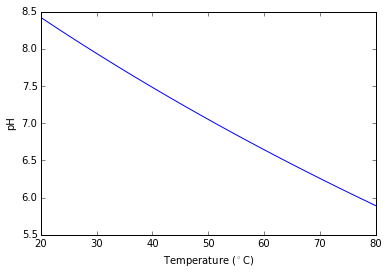

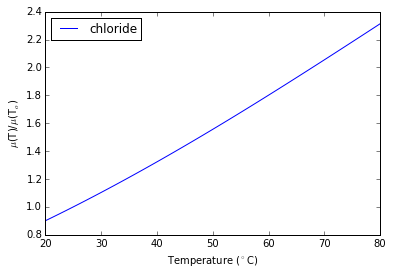

In [16]:
buffer_ref = ionize.Solution(['tris', 'hydrochloric acid'], [.200, .100], temperature=25.)
mu_ref = buffer_ref.ions[1].mobility()
mup = []
pH = []
I = []
mu=[]
cond = []
for Tp in T:
    buffer = ionize.Solution([tris, hcl], [.200, .100], temperature=Tp)
    mu.append(buffer.ions[1].mobility())
    mup.append(buffer.ions[1].mobility()/mu_ref)
    pH.append(buffer.pH)
    I.append(buffer.ionic_strength)
    cond.append(buffer.conductivity())
#     mup.append(hcl.nightingale_function(Tp))
cond_norm = [c / cond[0] for c in cond]
figure()
plot(T, pH); xlabel('Temperature ($^{\circ}$C)'); ylabel('pH')
show()

figure()
plot(T, mup, label='chloride'); xlabel('Temperature ($^{\circ}$C)'); ylabel('$\mu$(T)/$\mu$(T$_o$)'); legend(loc='upper left')
show()

Conservation Functions
--------------------
Conservation functions are spatially invariant quantities that remain constant as a solution undergoes electrophoresis. They are useful in calculating ion concentrations in zones formed during electrophoresis. 

### The Kohlrausch Regulating Function (KRF)
The most basic conservation function is the KRF. This function is only valid for strongly ionized species, when water dissociation doesn't play a strong role. Solutions can calculate their own KRF values. They throw a warning if they contain species that are not strongly ionized.

In [17]:
saltwater = ionize.Solution(['sodium', 'hydrochloric acid'], [0.1, 0.1])
print saltwater.kohlrausch()

878834124.446


In [18]:
print buffer_ref.ions
print buffer_ref.kohlrausch()

[Ion(name='tris', valence=[1], reference_pKa=[8.076], reference_mobility=[2.9500000000000003e-08], reference_temperature=25.0, enthalpy=[47450.0], heat_capacity=[-59.0], nightingale_data=None), Ion(name='hydrochloric acid', valence=[-1], reference_pKa=[-2.0], reference_mobility=[-7.91e-08], reference_temperature=25.0, enthalpy=[55815.0], heat_capacity=None, nightingale_data={u'max': 99.0894, u'fit': [-2.2137142181060233e-16, 8.863674452701262e-14, -1.4332969510592665e-11, 1.1888046230819577e-09, -5.145376056942322e-08, 7.923801398904878e-07, 3.3530212793127194e-05, -0.0032209848253299594, 0.7381662817975986], u'min': 0.3302})]
7922496361.31


ionize/Solution/conservation.py:18: UserWarning: ions are not fully ionized. KRF is a poor approx.
  warnings.warn('ions are not fully ionized. KRF is a poor approx.')


### The Alberty Conservation Function

The Alberty conservation function is useful for weakly ionized monovalent species, when water dissocation doesn't play a strong role. 

In [19]:
tcap = ionize.Solution(['tris', 'caproic acid'], [0.1, 0.05])
print tcap.alberty()


6430336429.82


ionize/Ion/mobility.py:42: UserWarning: Context failed to return an actual mobility.
  warnings.warn('Context failed to return an actual mobility.')


In [20]:
tcit = ionize.Solution(['tris', 'citric acid'], [0.1, 0.05])
print tcit.alberty()

6139637504.53


ionize/Solution/conservation.py:37: UserWarning: Ion not in single valance. Alberty invalid.
  warnings.warn('Ion not in single valance. Alberty invalid.')


### The Jovin Conservation Function

The Jovin conservation function is applicable under the same conditions that the Alberty conservation function is. It is often used as a compliment.

In [21]:
print tcap.jovin()

0.05


In [22]:
print tcit.jovin()

0.0


ionize/Solution/conservation.py:59: UserWarning: Ion not in single valance. Jovin invalid.
  warnings.warn('Ion not in single valance. Jovin invalid.')


### The Gas Conservation Functions

In [23]:
print tcap.gas()
print tcit.gas()

(6430190580.7034302, 6430597039.6188593)
(6139637504.5265999, 6139637504.5265999)


### Serialization, Saving, and Loading
You can also save and load ions and solutions in JSON format.